# Linear Regression Example - from scratch

In [1]:
# plot inside jupter
%matplotlib inline 

import random
import torch
from d2l import torch as d2l # import some functions defined by limu

## Generate fake data as training data (samples) 生成数据集

In [2]:
# generate some fake data

def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    """Generate y=Xw+b and noises for it"""
    # X is a tensor a random numbers which are drawn from a normal distributions whose mean is 0 and standard deviation is 1. 
    # It has num_examples rows, len(w) columns.
    X = torch.normal(0, 1, (num_examples, len(w))) #正态分布 均值为0 方差为1 的随机数。 行数：num_examples。 列数: len(w)
    y = torch.matmul(X, w) + b # y = Xw + b
    # Add some noises for y. The shape of the noises is as same as y's. 
    y += torch.normal(0, 0.01, y.shape) # 加点噪音，噪音形状和y的形状相同 
    
    # return y as a column vector
    return X, y.reshape((-1, 1)) # y变成列向量返回



In [3]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
true_w, true_b

(tensor([ 2.0000, -3.4000]), 4.2)

In [4]:
features, labels = synthetic_data(true_w, true_b, 1000)
features, labels

(tensor([[ 0.8006,  0.9743],
         [ 2.4280,  0.6781],
         [ 1.5014,  0.5912],
         ...,
         [-0.0977,  0.0870],
         [-1.7249,  0.1408],
         [ 0.0156,  0.5685]]),
 tensor([[ 2.4841e+00],
         [ 6.7416e+00],
         [ 5.1972e+00],
         [ 8.8286e+00],
         [ 4.4122e+00],
         [ 4.6563e-02],
         [ 5.4473e+00],
         [ 4.7880e+00],
         [ 1.7273e+00],
         [ 4.1323e+00],
         [-9.7965e-01],
         [ 1.1060e+01],
         [ 8.9942e+00],
         [ 2.2017e+00],
         [ 1.6260e+00],
         [ 3.2468e+00],
         [ 2.8793e+00],
         [ 6.9022e+00],
         [ 5.4559e+00],
         [ 3.6115e-02],
         [ 8.1487e+00],
         [ 9.8911e+00],
         [ 1.5074e+01],
         [ 2.3222e+00],
         [ 6.3460e+00],
         [-1.0050e+00],
         [-1.7092e+00],
         [ 2.8051e+00],
         [ 2.2577e+00],
         [ 2.3731e+00],
         [ 4.5359e+00],
         [-2.6802e+00],
         [ 6.5072e+00],
         [ 8.7925e

### Glance at the training data/samples 了解下数据集

In [5]:
# 训练样本 看下前十个样本
# Check the first 10 samples (10 rows) of the training data

features[:10], labels[:10]

(tensor([[ 0.8006,  0.9743],
         [ 2.4280,  0.6781],
         [ 1.5014,  0.5912],
         [ 1.4092, -0.5323],
         [-0.1808, -0.1670],
         [-0.4836,  0.9357],
         [ 0.2366, -0.2301],
         [-0.8320, -0.6680],
         [-1.2665, -0.0200],
         [-0.2546, -0.1307]]),
 tensor([[2.4841],
         [6.7416],
         [5.1972],
         [8.8286],
         [4.4122],
         [0.0466],
         [5.4473],
         [4.7880],
         [1.7273],
         [4.1323]]))

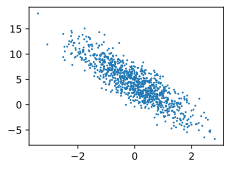

In [6]:
# 通过生成第二个特征features[:, 1]和labels的散点图， 可以直观观察到两者之间的线性关系。
# By generating a scatter plot of the second feature features[:, 1] and labels, 
# the linear relationship between the two can be visually observed.
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);
# We need detach() before numpy() to remove the additional computational graph layer which torch needs but numpy doesn't need: https://stackoverflow.com/questions/63582590/why-do-we-call-detach-before-calling-numpy-on-a-pytorch-tensor 

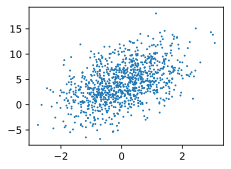

In [7]:
# Same way, we can check the linear relationship between the first feature and labels
d2l.plt.scatter(features[:, 0].detach().numpy(), labels.detach().numpy(), 1);

### Read samples with small batches 小批量读取数据集

训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型。 由于这个过程是训练机器学习算法的基础，所以有必要定义一个函数， 该函数能打乱数据集中的样本并以小批量方式获取数据。

在下面的代码中，我们[定义一个data_iter函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量]。 每个小批量包含一组特征和标签。

When training a model, it's necessary to iterate over the dataset, extracting a small batch of samples each time and using them to update our model. Since this process is the foundation of training machine learning algorithms, it is essential to define a function that can shuffle the samples in the dataset and fetch the data in small batches.

In the code below, we define a data_iter function, which takes the batch size, feature matrix, and label vector as input, and generates small batches of size batch_size. Each small batch contains a set of features and labels.

In [8]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [9]:
# The yield statement suspends a function’s execution and sends a value back to the caller, but retains enough state to enable the function to resume where it left off. When the function resumes, it continues execution immediately after the last yield run. This allows its code to produce a series of values over time, rather than computing them at once and sending them back like a list.
# https://www.geeksforgeeks.org/use-yield-keyword-instead-return-keyword-python/

通常，我们利用GPU并行运算的优势，处理合理大小的“小批量”。 每个样本都可以并行地进行模型计算，且每个样本损失函数的梯度也可以被并行计算。 GPU可以在处理几百个样本时，所花费的时间不比处理一个样本时多太多。

我们直观感受一下小批量运算：读取第一个小批量数据样本并打印。 每个批量的特征维度显示批量大小和输入特征数。 同样的，批量的标签形状与batch_size相等。

Typically, we take advantage of GPU parallel computing to process reasonably sized 'mini-batches'. Each sample can be processed by the model in parallel, and the gradient of each sample's loss function can also be computed in parallel. A GPU can process several hundred samples in nearly the same amount of time it takes to process a single sample.

Let's get an intuitive understanding of mini-batch processing: Read and print the first batch of sample data. The feature dimensions of each batch show the batch size and the number of input features. Similarly, the shape of the batch's labels is equal to the batch_size.

In [10]:
batch_size = 10

# 每次随机选取10个样本
# Fetch 10 random samples each time
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.3803, -0.8265],
        [ 1.4595,  0.9736],
        [-0.6952,  0.8436],
        [ 1.7162, -1.5694],
        [-0.1447,  1.6536],
        [-1.5006,  1.0163],
        [ 0.8478, -0.9336],
        [ 0.9373, -0.3100],
        [ 1.2252,  0.6762],
        [ 0.7978,  0.3138]]) 
 tensor([[ 7.7683],
        [ 3.8199],
        [-0.0439],
        [12.9805],
        [-1.7092],
        [-2.2581],
        [ 9.0519],
        [ 7.1129],
        [ 4.3422],
        [ 4.7281]])


当我们运行迭代时，我们会连续地获得不同的小批量，直至遍历完整个数据集。 上面实现的迭代对教学来说很好，但它的执行效率很低，可能会在实际问题上陷入麻烦。 例如，它要求我们将所有数据加载到内存中，并执行大量的随机内存访问。 在深度学习框架中实现的内置迭代器效率要高得多， 它可以处理存储在文件中的数据和数据流提供的数据。

When we run iterations, we continuously obtain different mini-batches until we have traversed the entire dataset. The iteration implemented above is good for teaching purposes, but it is very inefficient in execution and may run into trouble with real-world problems. For instance, it requires us to load all the data into memory and perform a large number of random memory accesses. The built-in iterators implemented in deep learning frameworks are much more efficient, as they can handle data stored in files and data provided by data streams.

至此，数据集就准备好了。

By now, the dataset is ready.

## Initializing model's parameters 初始化模型参数

[在我们开始用小批量随机梯度下降优化我们的模型参数之前]， (我们需要先有一些参数)。 在下面的代码中，我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重， 并将偏置初始化为0。

[Before we start optimizing our model parameters with mini-batch stochastic gradient descent], (we need to have some parameters). In the code below, we initialize the weights by sampling random numbers from a normal distribution with a mean of 0 and a standard deviation of 0.01, and we initialize the biases to 0.

In [11]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True) # Use random values as initiative parameters
b = torch.zeros(1, requires_grad=True)
w, b

(tensor([[-0.0011],
         [ 0.0045]], requires_grad=True),
 tensor([0.], requires_grad=True))

## Define the model 定义模型

接下来，我们必须[定义模型，将模型的输入和参数同模型的输出关联起来。] 

回想一下，要计算线性模型的输出， 我们只需计算输入特征和模型权重的矩阵-向量乘法后加上偏置。 注意，上面的是一个向量，而是一个标量。 回想一下广播机制： 当我们用一个向量加一个标量时，标量会被加到向量的每个分量上。

Next, we must [define the model, linking the model's input and parameters with the model's output.] 

Recall that to compute the output of a linear model, we simply need to perform the matrix-vector multiplication of the input features and the model weights, and then add the bias. Note that the former is a vector, while the latter is a scalar. Remember the broadcasting mechanism: when we add a vector to a scalar, the scalar is added to each component of the vector.

In [12]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    """Liner Regression Model"""
    return torch.matmul(X, w) + b

## Define the loss function 定义损失函数

因为需要计算损失函数的梯度，所以我们应该先定义损失函数。 这里我们使用平方损失函数。 在实现中，我们需要将真实值y的形状转换为和预测值y_hat的形状相同。

Since we need to compute the gradient of the loss function, we should first define the loss function. Here, we use the squared loss function. In implementation, we need to transform the shape of the true values y to be the same as the shape of the predicted values y_hat.

In [13]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## Define the Optimization AAlgorithm 定义优化算法

线性回归有解析解。 尽管线性回归有解析解，但常见其他模型却没有。 这里使用小批量随机梯度下降SGD。

在每一步中，使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度。 接下来，朝着减少损失的方向更新我们的参数。 下面的函数实现小批量随机梯度下降更新。 该函数接受模型参数集合、学习速率和批量大小作为输入。每 一步更新的大小由学习速率lr决定。 因为我们计算的损失是一个批量样本的总和，所以我们用批量大小（batch_size） 来规范化步长，这样步长大小就不会取决于我们对批量大小的选择。

Linear regression has an analytical solution. Although linear regression has an analytical solution, most other models do not. Here, we use mini-batch stochastic gradient descent (SGD).

In each step, we use a small batch randomly drawn from the dataset and then compute the gradient of the loss with respect to the parameters. Next, we update our parameters in the direction that reduces the loss. The following function implements the mini-batch stochastic gradient descent update. This function takes a set of model parameters, a learning rate, and a batch size as input. The size of each step update is determined by the learning rate lr. Since our computed loss is the sum of the losses for a batch of samples, we normalize the step size by the batch size (batch_size), so the step size does not depend on our choice of batch size.

In [14]:
def sgd(params, lr, batch_size):  #@save
    """Mini-batch SGD 小批量随机梯度下降"""
    with torch.no_grad(): # no gradient computing during updating
        for param in params: # params are w or b in our this case
            param -= lr * param.grad / batch_size # gradients were stored in param.grad # Here we divide by batch_size to calculate the mean, which can also be done in squared_loss().
            param.grad.zero_() # Reset gradients to zeros so next time when it calculates the gradients it will not be affected by these old gradients.

## Training 训练


现在我们已经准备好了模型训练所有需要的要素，可以实现主要的[**训练过程**]部分了。
理解这段代码至关重要，因为从事深度学习后，
相同的训练过程几乎一遍又一遍地出现。
在每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。
计算完损失后，我们开始反向传播，存储每个参数的梯度。
最后，我们调用优化算法`sgd`来更新模型参数。


Now that we have prepared all the necessary components for model training, we can implement the main [training process] part. Understanding this code is crucial because in deep learning, the same training process almost always appears over and over again. In each iteration, we read a small batch of training samples and obtain a set of predictions through our model. After calculating the loss, we start backpropagation, storing the gradient of each parameter. Finally, we call the optimization algorithm sgd to update the model parameters.

概括一下，我们将执行以下循环：

* 初始化参数
* 重复以下训练，直到完成
    * 计算梯度$\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * 更新参数$(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

在每个*迭代周期*（epoch）中，我们使用`data_iter`函数遍历整个数据集，
并将训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。
这里的迭代周期个数`num_epochs`和学习率`lr`都是超参数，分别设为3和0.03。
设置超参数很棘手，需要通过反复试验进行调整。


To summarize, we will execute the following loop:

* Initialize parameters
* Repeat the following training until completion
    * Compute the gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$
 
During each iteration cycle (epoch), we use the data_iter function to traverse the entire dataset, using all samples in the training dataset once (assuming that the number of samples is divisible by the batch size). The number of iteration cycles num_epochs and the learning rate lr are hyperparameters, set here to 3 and 0.03, respectively. Setting hyperparameters is tricky and requires adjustment through repeated experimentation.

In [15]:
lr = 0.03
num_epochs = 3 # 把整个数据集扫3遍 Go over the whole dataset 3 times
net = linreg # easy to change to other models in future
loss = squared_loss

In [16]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels): # Fetch batch_size samples until the whole dataset has been covered
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward() # Sum and then calculate the gradients using backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数 # Use gradients to update parameters w, b
    with torch.no_grad(): # 数据每扫完一遍之后 After each time we go over the whole dataset
        train_l = loss(net(features, w, b), labels) # 计算真实的loss；   features和labels的真实的损失
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.038848
epoch 2, loss 0.000148
epoch 3, loss 0.000053


因为我们使用的是自己合成的数据集，所以我们知道真正的参数是什么。 因此，我们可以通过[比较真实参数和通过训练学到的参数来评估训练的成功程度]。 事实上，真实参数和通过训练学到的参数确实非常接近。

Because we are using a dataset that we synthesized ourselves, we know what the true parameters are. Therefore, we can evaluate the success of the training by [comparing the true parameters with the parameters learned through training]. In fact, the true parameters and the parameters learned through training are indeed very close.

In [17]:
print(f'w的估计误差 The estimated error of w: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差 The estimated error of b: {true_b - b}')

w的估计误差 The estimated error of w: tensor([-0.0005,  0.0002], grad_fn=<SubBackward0>)
b的估计误差 The estimated error of b: tensor([5.4836e-05], grad_fn=<RsubBackward1>)


注意，我们不应该想当然地认为我们能够完美地求解参数。 在机器学习中，我们通常不太关心恢复真正的参数，而更关心如何高度准确预测参数。 幸运的是，即使是在复杂的优化问题上，随机梯度下降通常也能找到非常好的解。 其中一个原因是，在深度网络中存在许多参数组合能够实现高度精确的预测。

Note that we should not take for granted that we can perfectly solve for the parameters. In machine learning, we are usually less concerned with recovering the true parameters and more concerned with how to accurately predict them. Fortunately, even in complex optimization problems, stochastic gradient descent often finds very good solutions. One reason is that in deep networks, there are many combinations of parameters that can achieve highly accurate predictions.